# Credit Card Customers 

## 1. Pozivanje biblioteka

In [134]:
import warnings
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
import mpl_toolkits.mplot3d.axes3d as p3

from pylab import rcParams
from sklearn.cluster import KMeans   
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.metrics import silhouette_score
from datetime import datetime
from time import time
from time import sleep
import time
from random import random
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

In [135]:
warnings.filterwarnings('ignore')

## 2. Učitavanje podataka

In [136]:
dataset = pd.read_csv("Credit Card Customer Data with dates.csv")

In [137]:
dataset.head()

,Unnamed: 0,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,date
0,0,1,87073,100000,2,1,1,0,2019-03-22
1,1,2,38414,50000,3,0,10,9,2019-03-23
2,2,3,17341,50000,7,1,3,4,2019-03-24
3,3,4,40496,30000,5,1,1,4,2019-03-25
4,4,5,47437,100000,6,0,12,3,2019-03-26


##### Kolone:
##### Customer Key - sifra klijenta
##### Avg_Credit_Limit - kreditni limit
##### Total_Credit_Cards - broj kreditnih kartica
##### Total_visits_bank - ukupna poseta banci
##### Total_visits_online - ukupna online poseta banci
##### Total_calls_made - ukupni pozivi
##### date - datum

In [138]:
dataset.columns

Index(['Unnamed: 0', 'Sl_No', 'Customer Key', 'Avg_Credit_Limit',
       'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online',
       'Total_calls_made', 'date'],
      dtype='object')

In [139]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           660 non-null    int64 
 1   Sl_No                660 non-null    int64 
 2   Customer Key         660 non-null    int64 
 3   Avg_Credit_Limit     660 non-null    int64 
 4   Total_Credit_Cards   660 non-null    int64 
 5   Total_visits_bank    660 non-null    int64 
 6   Total_visits_online  660 non-null    int64 
 7   Total_calls_made     660 non-null    int64 
 8   date                 660 non-null    object
dtypes: int64(8), object(1)
memory usage: 46.5+ KB


## 3. Priprema podataka

### 3.1. Nedostajuce vrednosti

In [140]:
dataset.isnull().sum()

Unnamed: 0             0
Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
date                   0
dtype: int64

#### Zakljucujemo da nemamo nedostajuce vrednosti.

In [141]:
dataset.dtypes

Unnamed: 0              int64
Sl_No                   int64
Customer Key            int64
Avg_Credit_Limit        int64
Total_Credit_Cards      int64
Total_visits_bank       int64
Total_visits_online     int64
Total_calls_made        int64
date                   object
dtype: object

#### Kolona 'date' nije definisana kao datum, pomocu funkcije to_datetime formatiracemo kolonu 'date' u datum.

In [142]:
dataset['date'] = pd.to_datetime(dataset['date'], infer_datetime_format=True )

In [143]:
dataset.shape

(660, 9)

###### Skup podataka sadrzi 660 redova i 9 kolona.

In [144]:
dataset.describe()

,Unnamed: 0,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,329.500000,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,0.000000,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,164.750000,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,329.500000,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,494.250000,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,659.000000,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


#### Na osnovu deskriptivne statistike zakljucujemo da ima 660 klijenata, prosecni kreditni limit je 34574.24, prosecan broj kartica je 5, prosecan broj poseta je 2, online poseta 3, poziva 4. Zakljucujemo da postoji velika razlika izmedju 75. percentila i maksimalne vrednosti, to nam pokazuje da ima mali broj outliera ali znatno odstupaju od ostalih podataka po osnovu kreditnog limita.

In [145]:
dataset['Avg_Credit_Limit'].min()

3000

In [146]:
dataset['Avg_Credit_Limit'].max()

200000

#### Najmanji kreditni limit iznosi 3.000, najveci iznosi 200.000.

In [147]:
dataset['Customer Key'].nunique()

655

### 3.2. Agregacija podataka

In [148]:
prepared_data = dataset.groupby('Customer Key').agg({'Total_Credit_Cards': 'sum',
                                                     'Avg_Credit_Limit': 'sum',
                                                     'Total_visits_bank': 'sum',
                                                     'Total_visits_online': 'sum',
                                                     'Total_calls_made': 'sum',
                                                     'date': ['min', 'max'] 
                                                    })                     

In [149]:
prepared_data.reset_index(inplace=True)

#### Definisacemo indeks, ne zelimo da nam 'Customer ID' bude ujedno i indeks, zelimo da ga odvojimo.

### 3.3. Izbor kolona za modelovanje

In [150]:
prepared_data.columns = ['CustomerID','Total_Credit_Cards','MonetaryValue','Total_visits_bank','Total_visits_online', 'Total_calls_made', 'FirstPurchase', 'LastPurchase']

In [151]:
prepared_data['LastPurchase'].max()

Timestamp('2021-01-09 00:00:00')

In [152]:
prepared_data['ObservationDate'] = pd.to_datetime('2021-01-10')

#### Datum na osnovu kojeg cemo da racunamo koliko dana je proteklo od poslednje kupovine, bice dan nakon poslednje kupovine.

In [153]:
prepared_data.dtypes

CustomerID                      int64
Total_Credit_Cards              int64
MonetaryValue                   int64
Total_visits_bank               int64
Total_visits_online             int64
Total_calls_made                int64
FirstPurchase          datetime64[ns]
LastPurchase           datetime64[ns]
ObservationDate        datetime64[ns]
dtype: object

In [154]:
prepared_data['Recency'] = (prepared_data['ObservationDate']-prepared_data['LastPurchase']).dt.days

#### Kolona 'Recency' nam pokazuje koliko dana je proslo od poslednje kupovine.

In [155]:
prepared_data = prepared_data[['CustomerID', 'Total_Credit_Cards', 'MonetaryValue','Total_visits_bank','Total_visits_online','Total_calls_made','Recency']]

In [156]:
prepared_data.head()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency
0,11265,7,51000,3,2,0,210
1,11398,6,12000,5,2,1,282
2,11412,2,19000,2,3,4,481
3,11466,7,9000,5,0,0,339
4,11562,4,38000,3,2,0,51


In [157]:
prepared_data.describe()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,55058.158779,4.741985,34838.167939,2.421374,2.625954,3.610687,329.447328
std,25606.965469,2.229012,38000.419397,1.657944,2.952571,2.869678,190.407385
min,11265.000000,1.000000,3000.000000,0.000000,0.000000,0.000000,1.000000
25%,33623.500000,3.000000,10000.000000,1.000000,1.000000,1.000000,164.500000
50%,53898.000000,5.000000,18000.000000,2.000000,2.000000,3.000000,330.000000
75%,77084.500000,6.000000,48500.000000,4.000000,4.000000,5.000000,493.500000
max,99843.000000,13.000000,204000.000000,10.000000,15.000000,10.000000,660.000000


#### Na osnovu deskriptivne statistike zakljucujemo da ima 655 transakcija, prosecni kreditni limit je 34838.17, prosecan broj kartica je 5, prosecan broj poseta je 2, online poseta 3, poziva 4, prosecan broj dana koji su prosli od poslednje kupovine je 329.

## 4. Vizualizacija

### 4.1. Histogram

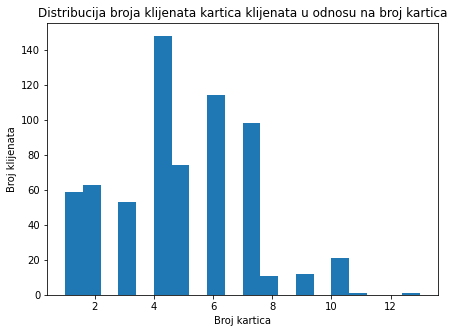

In [158]:
plt.figure(figsize=[7,5])    
plt.hist(prepared_data['Total_Credit_Cards'], bins=20)  

plt.ylabel('Broj klijenata')  
plt.xlabel('Broj kartica') 
plt.title('Distribucija broja klijenata kartica klijenata u odnosu na broj kartica'); 

###### Na osnovu histograma, zakljucujemo da najveci broj klijenata ima 4 kartice, dok veoma mali broj klijenata ima preko 12 kartica.

### 4.2. Distplot

<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

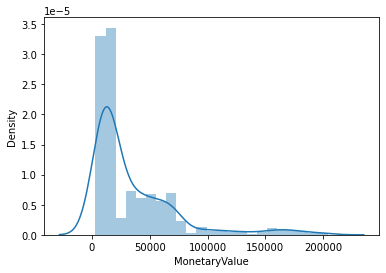

In [159]:
sns.distplot(prepared_data['MonetaryValue'])

###### Zakljucujemo da podaci ne slede normalan raspored. U velikoj meri imamo odstupanja, najveci broj klijenata ima monetarnu vrednost do 10.000.

### 4.3. Boxplot

<AxesSubplot:xlabel='Total_Credit_Cards', ylabel='MonetaryValue'>

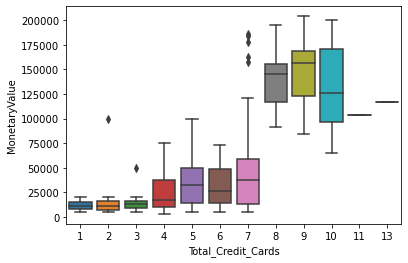

In [215]:
sns.boxplot(x="Total_Credit_Cards", y="MonetaryValue", data=prepared_data, palette='tab10')

#### Boxplot nam pokazuje odnos izmedju broja kartice i kreditnog limita. Zakljucujemo da postoje outlier-i kod kartica 2, 3 i 7. Oni predstavljaju prave outlier-e. Oni bi trebalo da se izbrisu iz podataka ali smo ih mi sada ostavili da bismo uvideli da li su to transakcije koje su prevare ili je rec o klijentima koji imaju veliki znacaj za banku.

In [161]:
Q1 = prepared_data.quantile(0.25)
Q3 = prepared_data.quantile(0.75)
IQR = Q3 - Q1

In [162]:
((prepared_data > (Q3 + 1.5 * IQR))).sum()

CustomerID              0
Total_Credit_Cards      2
MonetaryValue          39
Total_visits_bank       1
Total_visits_online    38
Total_calls_made        0
Recency                 0
dtype: int64

### 4.4. Stripplot

<AxesSubplot:xlabel='Total_visits_bank', ylabel='Total_visits_online'>

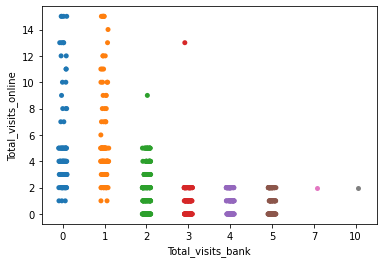

In [163]:
sns.stripplot(x="Total_visits_bank", y="Total_visits_online", data=prepared_data)

#### Stripplot nam pokazuje odnos izmedju ukupnog broja poseta banke uzivo i ukupnog broja online poseta banke. Zakljucujemo da sa minimalnim posetama uzivo ima najveci broj online poseta. Sa povecanjem broja uzivo poseta, smanjuje se broj online poseta. Takodje, postoje i outlier-i.

In [164]:
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   CustomerID           655 non-null    int64
 1   Total_Credit_Cards   655 non-null    int64
 2   MonetaryValue        655 non-null    int64
 3   Total_visits_bank    655 non-null    int64
 4   Total_visits_online  655 non-null    int64
 5   Total_calls_made     655 non-null    int64
 6   Recency              655 non-null    int64
dtypes: int64(7)
memory usage: 35.9 KB


## 5. Modelovanje rešenja : RFM clustering

### 5.1. Normalizacija podataka

In [165]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [166]:
scaler.fit(prepared_data[['Total_Credit_Cards', 'MonetaryValue',
                         'Total_visits_bank', 'Total_visits_online',
                         'Total_calls_made','Recency']])

MinMaxScaler(feature_range=(-1, 1))

In [167]:
normalized_data = scaler.transform(prepared_data[['Total_Credit_Cards','MonetaryValue',
                         'Total_visits_bank', 'Total_visits_online',
                         'Total_calls_made','Recency']])

## Verzija 1: K means clustering

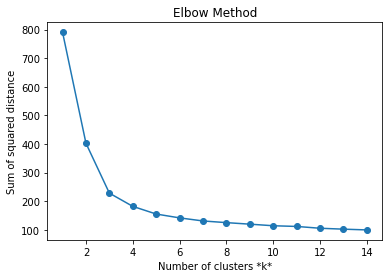

In [168]:
sse = []

for k in range(1, 15):
    km = KMeans(n_clusters=k)
    km.fit(normalized_data)
    sse.append(km.inertia_)

plt.plot(range(1, 15), sse, '-o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters *k*')
plt.ylabel('Sum of squared distance');

#### Broj klastera odredjujemo na osnovu krive, zakljucujemo da nakon 10. klastera kriva pocinje da se ravna, tako da cemo izabrati 10 klastera.

In [169]:
model = KMeans(n_clusters=10)

##### model = KMeans(n_clusters=6)
##### Ukoliko bi definisali 6 klastera bio bi nam dosta manji Silhouette Coefficient zato smo ostavili 12.

##### model = KMeans(n_clusters=12)
##### Probali smo i da definisemo 12 klastera ali je Silhouette Coefficient isti pa nema potreba da ostaje veci broj klastera.

In [170]:
model.fit(normalized_data)

KMeans(n_clusters=10)

In [171]:
centroids = model.cluster_centers_

In [172]:
centroids = scaler.inverse_transform(centroids)

In [173]:
centroids_dataset = pd.DataFrame(centroids, columns=['Total_Credit_Cards', 'MonetaryValue',
                         'Total_visits_bank', 'Total_visits_online',
                         'Total_calls_made','Recency'])

In [174]:
prepared_data['KMeans_Cluster_id'] = model.labels_

In [175]:
prepared_data.head()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id
0,11265,7,51000,3,2,0,210,9
1,11398,6,12000,5,2,1,282,2
2,11412,2,19000,2,3,4,481,5
3,11466,7,9000,5,0,0,339,2
4,11562,4,38000,3,2,0,51,9


In [176]:
prepared_data['KMeans_Cluster_id'].value_counts()

2    86
6    85
9    83
4    81
1    79
0    75
5    65
7    52
8    25
3    24
Name: KMeans_Cluster_id, dtype: int64

#### Pozivanjem ove funkcije dobijamo broj transakcija koji sadrzi svaki klaster. 

In [216]:
# Analiza klastera br. 6
cl2 = prepared_data[prepared_data["KMeans_Cluster_id"] == 2]
cl2.describe()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id,Affinity_Cluster_id,AgglomerativeClustering_id
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.0,86.000000,86.000000
mean,53093.488372,5.465116,12860.465116,3.465116,1.011628,0.744186,347.895349,2.0,5.174419,62.116279
std,25313.863204,1.113528,5113.218834,1.204869,0.874396,0.689178,50.248565,0.0,2.229175,36.222001
min,11398.000000,4.000000,5000.000000,2.000000,0.000000,0.000000,248.000000,2.0,1.000000,6.000000
25%,31724.250000,4.000000,8000.000000,2.000000,0.000000,0.000000,308.250000,2.0,3.000000,34.000000
50%,51918.000000,6.000000,12000.000000,3.000000,1.000000,1.000000,347.500000,2.0,6.000000,63.000000
75%,71816.750000,6.000000,17000.000000,5.000000,2.000000,1.000000,392.750000,2.0,6.000000,89.000000
max,97109.000000,7.000000,31000.000000,5.000000,2.000000,2.000000,432.000000,2.0,14.000000,124.000000


#### Klaster 6 obuhvata 86 transakcija, posmatracemo ga zato sto je to klaster koji ima najvise transakcija. Prosecna frekvencija je 5, prosecna monetarna vrednost iznosi 12860.46, prosecni broj dana koji su protekli od poslednje kupovine je 348. Prosecni broj poseta banci 3, online poseta 1, poziva 1.

In [179]:
# Analiza klastera br. 3
cl3 = prepared_data[prepared_data["KMeans_Cluster_id"] == 3]
cl3.describe()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.0
mean,48245.583333,8.875000,134041.666667,0.708333,8.500000,1.083333,23.708333,3.0
std,24625.019576,1.034723,31137.114952,0.464306,1.414214,0.775532,13.728673,0.0
min,13315.000000,7.000000,91000.000000,0.000000,6.000000,0.000000,3.000000,3.0
25%,28196.750000,8.000000,104250.000000,0.000000,7.000000,0.750000,12.750000,3.0
50%,50045.500000,9.000000,137500.000000,1.000000,8.000000,1.000000,23.000000,3.0
75%,67056.000000,10.000000,157750.000000,1.000000,10.000000,2.000000,34.250000,3.0
max,91575.000000,10.000000,186000.000000,1.000000,11.000000,2.000000,47.000000,3.0


#### Klaster 3 obuhvata 24 transakcija, posmatracemo ga zato sto je to klaster koji ima najmanje transakcija. Prosecna frekvencija je 9, prosecna monetarna vrednost iznosi 148541.67, prosecni broj dana koji su protekli od poslednje kupovine je 38. Prosecni broj poseta banci 1, online poseta 13, poziva 1.

### I ako smo imali veliki broj outliera, koji su bili klijenti sa 7 kreditnih kartica, nismo ih izbacili jer smo na osnovu dalje analize zakljucili da nije rec o laznim transakcijama vec o redovnim klijentima koji imaju veliki kreditni limit ali nemaju srazmerno tome dovoljan broj kartica. Ovi se klijenti puno razlikuju od ostalih po osnovu svoje monetarne vrednosti ali imaju veliki znacaj za banku jer su to njeni redovni klijenti. 

In [180]:
labels = km.labels_

In [181]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, km.labels_, metric='euclidean'))

Silhouette Coefficient: 0.192


Text(0.5, 0.92, 'Without connectivity constraints (time %.2fs)')

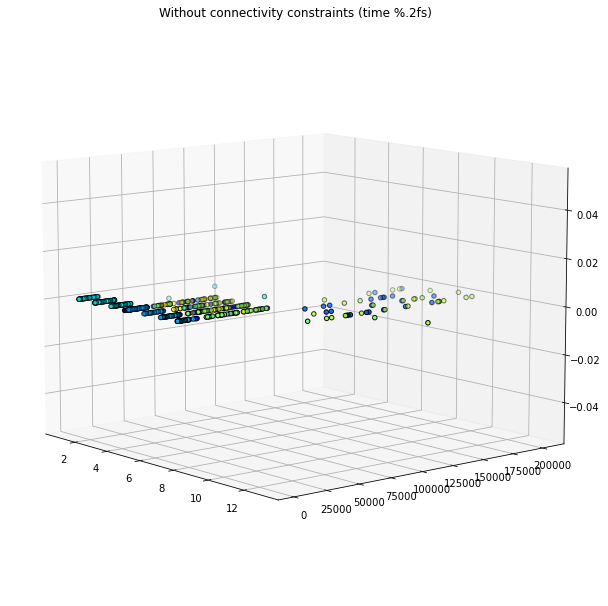

In [182]:
fig = plt.figure(figsize=(8,8))
ax = p3.Axes3D(fig)
ax.view_init(10, -40)
for l in np.unique(labels):
    ax.scatter(prepared_data[prepared_data['KMeans_Cluster_id'] == l]['Total_Credit_Cards'],
               prepared_data[prepared_data['KMeans_Cluster_id'] == l]['MonetaryValue'],
               color=plt.cm.jet(float(l) / np.max(labels + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)')

#### Na osnovu provere ugla posmatranja, zakljucujemo da se pod uglom od -40 najrelevantnije vidi kako su grupisani klasteri.

Text(0.5, 0.92, 'Without connectivity constraints (time %.2fs)')

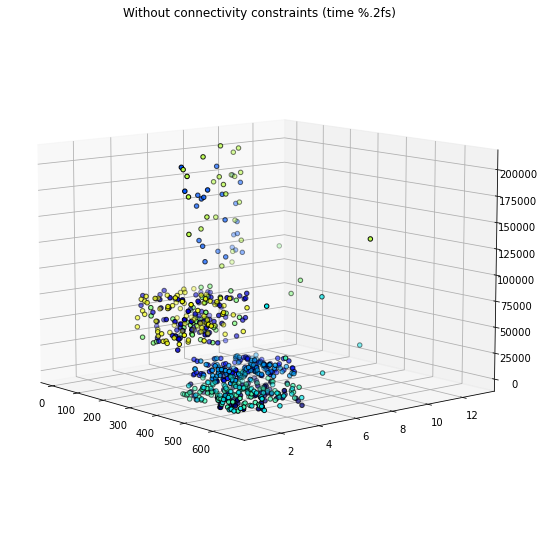

In [183]:
fig = plt.figure(figsize=(10,7))
ax = p3.Axes3D(fig)
ax.view_init(10, -40)
for l in np.unique(labels):
    ax.scatter(prepared_data[prepared_data['KMeans_Cluster_id'] == l]['Recency'],
               prepared_data[prepared_data['KMeans_Cluster_id'] == l]['Total_Credit_Cards'],
               prepared_data[prepared_data['KMeans_Cluster_id'] == l]['MonetaryValue'],
               color=plt.cm.jet(float(l) / np.max(labels + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)')

#### Na osnovu provere ugla posmatranja, zakljucujemo da se pod uglom od -40 najrelevantnije vidi kako su grupisani klasteri.

#### Zakljucak
##### Na osnovu sprovedene analize na bazi K-means klasterzacije došli smo da zakljucka da su podaci klasterizovani u 10 grupa. Svaka grupa podrazumeva odredjene karakteristike na osnovu kojih su podaci dodeljeni toj grupi. 
##### Klaster 0: klijenti najviše komuniciraju sa bankom online, imaju veliki broj kreditinih kartica, veliki kreditni limit ( najveci od svih klastera ) i mali broj dana od poslednje kupovine.
##### Klaster 1: klijenti najviše posećuju banku uživo, imaju veliki broj kreditnih kartica, srednji kreditni limit i srednji broj dana od poslednje kupovine. 
##### Klaster 2: klijenti imaju najviše uzivo poseta banci, mali kreditni limit  i veliki broj dana je prošlo do poslednje kupovine. 
##### Klaster 3: klijenti najviše komuniciraju sa bankom online, imaju veliki broj kreditnih kartica i mali broj dana od poslednje kupovine. 
##### Klaster 4: klijenti najviše komuniciraju sa bankom uzivo, imaju srednji kreditni limit, proslo je srednji broj dana od poslednje kupovine.
##### Klaster 5: klijenti najviše posecuju banku online, imaju mali broj kreditnih kartica, imaju mali kreditni limit, proslo je veliki broj dana od poslednje kupovine.
##### Klaster 6: klijenti najviše posećuju banku uživo, imaju veliki broj kreditnih kartica, mali kreditni limit i srednji broj dana od poslednje kupovine. 
##### Klaster 7: klijenti najviše komuniciraju putem poziva, imaju do 4 kreditinih kartica, mali kreditni limit i veliki broj dana od poslednje kupovine.
##### Klaster 8: klijenti imaju najviše uzivo poseta banci, mali kreditni limit  i mali broj dana je prošlo do poslednje kupovine.
##### Klaster 9: klijenti najviše komuniciraju sa bankom online, imaju veliki broj kreditnih kartica i mali broj dana od poslednje kupovine. 

#### Klasterima 0, 3 i 9 pripadaju lojalni klijenti koji imaju veliki kreditni limit, savetujemo da obratite paznju na njih, ima ih dosta manje u odnosu na one nelojalne. Predlazemo da im odobrite neki vid beneficija da bi ih motivisali da ostanu lojalni.

###### Primenom K means klasterizacije Silhouette Coefficient iznosi 0.192.

## Verzija 2: Affinity propagation 

In [184]:
af = AffinityPropagation(damping=0.9).fit(normalized_data)

In [185]:
cluster_centers_indices = af.cluster_centers_indices_

In [186]:
cluster_centers = af.cluster_centers_

In [187]:
num_of_clusters = af.labels_

In [188]:
pd.DataFrame(num_of_clusters).value_counts()

0     51
21    43
4     41
3     38
6     36
1     33
2     31
20    31
14    31
5     30
15    29
26    29
10    27
9     27
12    25
17    25
24    22
23    21
22    19
8     17
13    17
19    15
7     12
18     2
16     1
25     1
11     1
dtype: int64

#### Pozivanjem ove funkcije dobijamo broj transakcija koji sadrzi svaki klaster. 

In [189]:
prepared_data['Affinity_Cluster_id'] = num_of_clusters

In [190]:
prepared_data.head()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id,Affinity_Cluster_id
0,11265,7,51000,3,2,0,210,9,9
1,11398,6,12000,5,2,1,282,2,6
2,11412,2,19000,2,3,4,481,5,22
3,11466,7,9000,5,0,0,339,2,6
4,11562,4,38000,3,2,0,51,9,9


In [191]:
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

In [192]:
# Analiza klastera br. 0
cl0 = prepared_data[prepared_data["Affinity_Cluster_id"] == 0]
cl0.describe()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id,Affinity_Cluster_id
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0
mean,53611.137255,2.019608,12235.294118,0.784314,3.745098,6.137255,582.686275,0.980392,0.0
std,26910.125644,1.067524,5155.921781,0.756670,1.110732,0.721654,46.575311,2.004896,0.0
min,12026.000000,1.000000,3000.000000,0.000000,1.000000,5.000000,455.000000,0.000000,0.0
25%,30133.000000,1.000000,8000.000000,0.000000,3.000000,6.000000,555.500000,0.000000,0.0
50%,52326.000000,2.000000,13000.000000,1.000000,4.000000,6.000000,585.000000,0.000000,0.0
75%,76764.500000,3.000000,17000.000000,1.000000,5.000000,7.000000,621.000000,0.000000,0.0
max,99596.000000,4.000000,20000.000000,2.000000,5.000000,7.000000,651.000000,5.000000,0.0


#### Prvo smo posmatrali klaster koji ima najveci broj klijenata. Klaster 0 obuhvata 51 transakciju, prosecna frekvencija je 2.02, prosecna monetarna vrednost iznosi 12235.29, prosecni broj dana koji su protekli od poslednje kupovine je 583. Prosecni broj poseta banci 1, online poseta 4, poziva 6.¶

In [193]:
# Analiza klastera br. 7
cl7 = prepared_data[prepared_data["Affinity_Cluster_id"] == 7]
cl7.describe()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id,Affinity_Cluster_id
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0
mean,52411.750000,9.333333,102333.333333,0.833333,8.833333,1.083333,22.333333,3.416667,7.0
std,24504.077754,0.887625,11718.930554,0.389249,2.037527,0.900337,14.079859,1.443376,0.0
min,13315.000000,8.000000,84000.000000,0.000000,6.000000,0.000000,4.000000,3.000000,7.0
25%,37805.250000,8.750000,95500.000000,1.000000,7.750000,0.000000,11.750000,3.000000,7.0
50%,50853.000000,10.000000,98500.000000,1.000000,8.000000,1.000000,21.000000,3.000000,7.0
75%,63292.500000,10.000000,111250.000000,1.000000,10.250000,2.000000,28.250000,3.000000,7.0
max,91575.000000,10.000000,126000.000000,1.000000,13.000000,2.000000,47.000000,8.000000,7.0


###### Affinity propagation je definisao klaster 7 koji ima samo 12 klijenata u tom klasteru. Klaster 7 obuhvata 12 transakcija, prosecna frekvencija je 9.33, prosecna monetarna vrednost iznosi 102333.33, prosecni broj dana koji su protekli od poslednje kupovine je 12. Prosecni broj , poseta banci 1, online poseta 9, poziva 1.¶

In [194]:
# Analiza klastera br. 11
cl11 = prepared_data[prepared_data["Affinity_Cluster_id"] == 11]
cl11.head()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id,Affinity_Cluster_id
193,37252,10,65000,2,3,10,228,7,11


###### Affinity propagation je definisao klaster 11 i ima samo 1 klijenta u klasteru. K means je ovog klijenta dodelila klasteru 5 ali predstavlja outlier sa znatno vecom monetarnom vrednoscu i vecim brojem kreditnih kartica.

In [195]:
n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, labels, metric='sqeuclidean'))

Estimated number of clusters: 27
Silhouette Coefficient: 0.256


Text(0.5, 0.92, 'Without connectivity constraints (time %.2fs)')

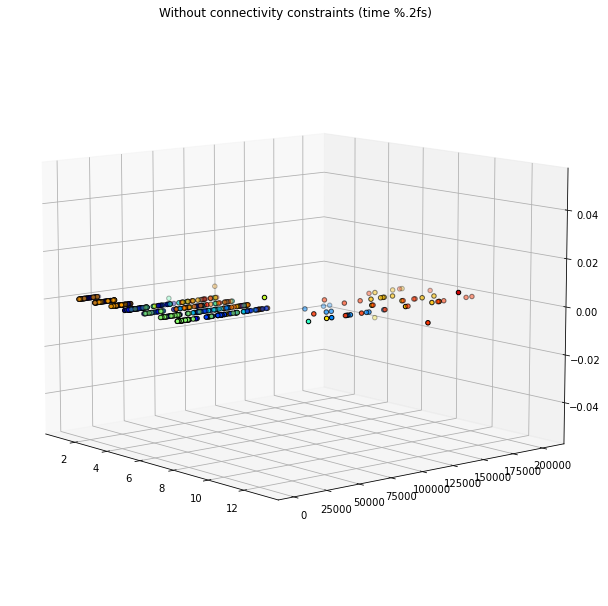

In [196]:
fig = plt.figure(figsize=(8,8))
ax = p3.Axes3D(fig)
ax.view_init(10, -40)
for l in np.unique(labels):
    ax.scatter(prepared_data[prepared_data['Affinity_Cluster_id'] == l]['Total_Credit_Cards'],
               prepared_data[prepared_data['Affinity_Cluster_id'] == l]['MonetaryValue'],
               color=plt.cm.jet(float(l) / np.max(labels + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)')

#### Na osnovu provere ugla posmatranja, zakljucujemo da se pod uglom od -40 najrelevantnije vidi kako su grupisani klasteri.

## Zakljucak
##### Affinity Propagation pokazuje sličnost između tačaka, identifikuje primere i razmenjuje poruke između tačaka. Ako je vrednost izmedju tačaka 0, znači da se oni  odlično mapiraju jedan u drugi i na taj način se javlja veći broj klastera, što je broj negativniji, onda se on grupiše u slične klastere. Na osnovu odgovornosti i dostupnosti se odredjuje kojem primerku će biti dodeljen element. Samo visoko odgovornom i visoko dostpunom elementu.

##### Na osnovu sprovedene analize na bazi Affinity propagation klasterzacije došli smo da zaključka da su podaci klasterizovani u 27 grupa. 
##### Podaci su grupisani u više grupa u odnosu na K means klasetrizaciju ali poređenjem ove dve klasterizacije došli smo do zaključka da su iste klijente klasterizovali na isti način, razlika je tome što ih je Affinity propagation razložila na detaljnije klastere, odnosno outlier-e je smestio u posebne klastere.

###### Primenom Affinity propagation klasterizacije Silhouette Coefficient iznosi 0.256.

## Verzija 3: Hierarchical clustering

In [197]:
ward = AgglomerativeClustering(n_clusters = None, linkage='ward',distance_threshold = 0.6).fit(normalized_data)

In [198]:
n_clusters_ = ward.n_clusters_

In [199]:
n_clusters_

130

In [200]:
label = ward.labels_

In [201]:
clusters__ = ward.labels_

In [202]:
pd.DataFrame(clusters__).value_counts()

58     11
43     11
0      10
13     10
15     10
       ..
109     1
108     1
107     1
67      1
83      1
Length: 130, dtype: int64

#### Pozivanjem ove funkcije dobijamo broj transakcija koji sadrzi svaki klaster. 

In [203]:
prepared_data['AgglomerativeClustering_id'] = clusters__

In [204]:
prepared_data.head()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id,Affinity_Cluster_id,AgglomerativeClustering_id
0,11265,7,51000,3,2,0,210,9,9,66
1,11398,6,12000,5,2,1,282,2,6,101
2,11412,2,19000,2,3,4,481,5,22,77
3,11466,7,9000,5,0,0,339,2,6,88
4,11562,4,38000,3,2,0,51,9,9,52


In [205]:
# Analiza klastera br. 58
cl58 = prepared_data[prepared_data["AgglomerativeClustering_id"] == 58]
cl58.describe()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id,Affinity_Cluster_id,AgglomerativeClustering_id
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.0
mean,52528.000000,1.545455,11454.545455,1.545455,4.272727,7.818182,465.818182,4.909091,26.0,58.0
std,25782.273527,0.522233,4824.181513,0.522233,0.786245,0.404520,22.341970,2.427120,0.0,0.0
min,15546.000000,1.000000,6000.000000,1.000000,3.000000,7.000000,433.000000,0.000000,26.0,58.0
25%,38307.500000,1.000000,8000.000000,1.000000,4.000000,8.000000,451.500000,6.000000,26.0,58.0
50%,55849.000000,2.000000,9000.000000,2.000000,4.000000,8.000000,467.000000,6.000000,26.0,58.0
75%,64506.000000,2.000000,16000.000000,2.000000,5.000000,8.000000,479.500000,6.000000,26.0,58.0
max,98288.000000,2.000000,19000.000000,2.000000,5.000000,8.000000,503.000000,6.000000,26.0,58.0


###### Ovaj metod je definisao klaster 58 koji ima najvise klijenata. Klaster 58 obuhvata 11 transakcija, prosecna frekvencija je 1.55, prosecna monetarna vrednost iznosi 11454,55, prosecni broj dana koji su protekli od poslednje kupovine je 456. Prosecni broj poseta banci 2 online poseta 4, poziva 8.

In [206]:
# Analiza klastera br. 54
cl54 = prepared_data[prepared_data["AgglomerativeClustering_id"] == 54]
cl54.describe()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id,Affinity_Cluster_id,AgglomerativeClustering_id
count,4.000000,4.000000,4.000000,4.00,4.00000,4.00000,4.000000,4.000000,4.0,4.0
mean,54026.750000,2.000000,9000.000000,1.75,2.50000,5.50000,474.500000,2.500000,15.0,54.0
std,16671.862691,0.816497,2160.246899,0.50,0.57735,0.57735,6.658328,2.886751,0.0,0.0
min,37671.000000,1.000000,6000.000000,1.00,2.00000,5.00000,469.000000,0.000000,15.0,54.0
25%,45800.250000,1.750000,8250.000000,1.75,2.00000,5.00000,470.500000,0.000000,15.0,54.0
50%,50646.500000,2.000000,9500.000000,2.00,2.50000,5.50000,472.500000,2.500000,15.0,54.0
75%,58873.000000,2.250000,10250.000000,2.00,3.00000,6.00000,476.500000,5.000000,15.0,54.0
max,77143.000000,3.000000,11000.000000,2.00,3.00000,6.00000,484.000000,5.000000,15.0,54.0


###### Ovaj metod je definisao klaster 54 koji ima samo cetiri klijenta. Kod K means klasterizacije oni pripadaju klasteru 3 i predstavljaju outlier-e tog klastera, zato sto ima vise kreditnih kartica i manje poziva.

In [207]:
# Analiza klastera br. 83
cl83 = prepared_data[prepared_data["AgglomerativeClustering_id"] == 83]
cl83.describe()

,CustomerID,Total_Credit_Cards,MonetaryValue,Total_visits_bank,Total_visits_online,Total_calls_made,Recency,KMeans_Cluster_id,Affinity_Cluster_id,AgglomerativeClustering_id
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,38414.0,3.0,50000.0,0.0,10.0,9.0,659.0,6.0,12.0,83.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,38414.0,3.0,50000.0,0.0,10.0,9.0,659.0,6.0,12.0,83.0
25%,38414.0,3.0,50000.0,0.0,10.0,9.0,659.0,6.0,12.0,83.0
50%,38414.0,3.0,50000.0,0.0,10.0,9.0,659.0,6.0,12.0,83.0
75%,38414.0,3.0,50000.0,0.0,10.0,9.0,659.0,6.0,12.0,83.0
max,38414.0,3.0,50000.0,0.0,10.0,9.0,659.0,6.0,12.0,83.0


###### Ovaj metod je definisao klaster broj 83 koji ima samo jednog klijenta. Kod K means klasterizacije oni pripadaju klasteru 3 i predstavlja outlier tog klastera.

In [208]:
st = time.time()

In [209]:
elapsed_time = time.time() - st

In [210]:
label = ward.labels_

In [211]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, ward.labels_, metric='euclidean'))

Silhouette Coefficient: 0.202


In [212]:
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters= 130, linkage='ward').fit(normalized_data)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Compute unstructured hierarchical clustering...
Elapsed time: 0.01s
Number of points: 655


Text(0.5, 0.92, 'Without connectivity constraints (time 0.01s)')

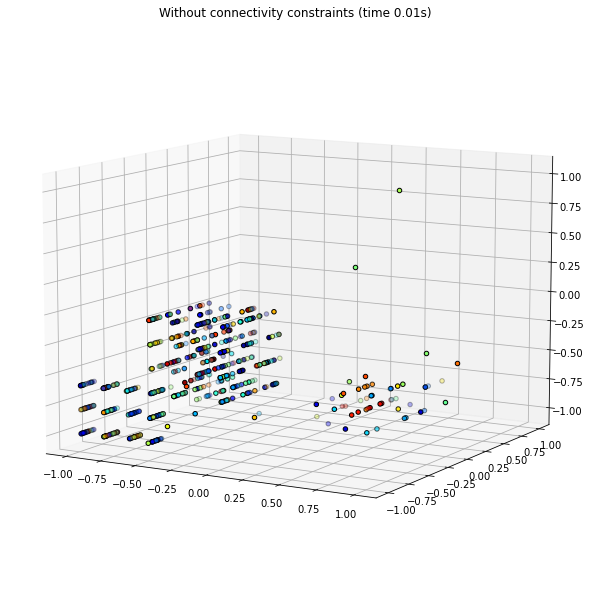

In [213]:
fig = plt.figure(figsize=(10,8))
ax = p3.Axes3D(fig)
ax.view_init(10, -60)
for l in np.unique(label):
    ax.scatter(normalized_data[label == l, 0], normalized_data[label == l, 1], normalized_data[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)

#### Na osnovu provere ugla posmatranja, zakljucujemo da se pod uglom od -60 najrelevantnije vidi kako su grupisani klasteri.

## Zakljucak
##### Hierarchical clustering je predstavljen u obliku 3D grafika.

##### Na osnovu sprovedene analize došli smo do zaključka da su primenom Hierarchical klasterizacije klijenti grupisani u 130 klastera. Ova metoda klasterizacije je razvrstala klijente na još sitnije klastere u odnosu na prethodne dve metode.

###### Primenom Hierarchical klasterizacije Silhouette Coefficient iznosi 0.202.

## 6. Donosenje odluke

#### Na osnovu dobijenih rezultata primenom tri metoda klasterizacije, zaključujemo da je najbolje primeniti Affinity propagation klasterizaciju. Kod ovog metoda klasterizacije, Silhouette Coefficient je najviši i iznosi 0.256. Ovaj koeficijent nam pokazuje koliko nam je metod dobar i koliko pravilno klasteriše podatke. Primecujemo da ima veliki broj klijenata koji veoma dugo nisu koristili usluge kreditnih kartica, predlazemo da im ponudite odredjene povoljnosti pri koriscenju kreditnih kartica, na primer za svaku kupovinu iznad 5000, iznos se moze podeliti na 12 mesecnih rata. Klijenata koji redovno koriste kreditne kartice imaju znatno manje u odnosu na one koji nisu dugo koristili, ima ih samo 125. Takodje kao sto smo napomenuli imal najmanji broj klijenata koji imaju preko 50000 monetarne vrednosti, program ih definise kao outlier-e jer znatno odstupaju ali su oni nasuprot tome veoma vazni i lojalni klijenti, ne treba odbaciti informacije o njima. Nas je predlog da ih nagradite za lojalnost.